## Relevant resources
- API keys: https://towardsdatascience.com/how-to-hide-your-api-keys-in-python-fb2e1a61b0a0
- python wrapper for binance api: https://github.com/sammchardy/python-binance

In [6]:
# import packages
from binance.client import Client
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd



# get api keys for binance 
import os
API_PUBLIC = os.environ.get("PUBLIC_KEY")
API_SECRET = os.environ.get("SECRET_KEY")

Determine first available price point

In [7]:
client = Client(API_PUBLIC, API_SECRET)
timestamp = client._get_earliest_valid_timestamp('BNBUSDT', '1d')

In [8]:
timestamp

1509926400000

In [9]:
startdate = timestamp #"1 Jan, 2019"
klines = client.get_historical_klines("BNBUSDT", '1d', startdate)

In [10]:
# delete unwanted data - just keep date, open, high, low, close
for line in klines:
    del line[5:]

In [11]:
df = pd.DataFrame(klines, columns=['date', 'open', 'high', 'low', 'close']) # ignoring other columns
# df['date'] = pd.to_datetime(df['date'],unit='D', origin=pd.Timestamp('1960-01-01'))
df['date'] = pd.to_datetime(df['date'],unit='ms')
df.set_index('date', inplace=True)
print(df.head())

                  open        high         low       close
date                                                      
2017-11-06  1.50000000  1.79900000  0.50000000  1.57100000
2017-11-07  1.57100000  1.80000000  1.53890000  1.80000000
2017-11-08  1.79010000  1.99000000  1.74790000  1.98890000
2017-11-09  1.97810000  2.19970000  1.90000000  1.99000000
2017-11-10  1.99000000  2.02000000  1.60190000  1.71330000


In [20]:
df.index[1000]

Timestamp('2020-08-02 00:00:00')

In [33]:
df.dtypes

open     object
high     object
low      object
close    object
dtype: object

In [27]:
df.plot(close, kind = 'line')

NameError: name 'close' is not defined

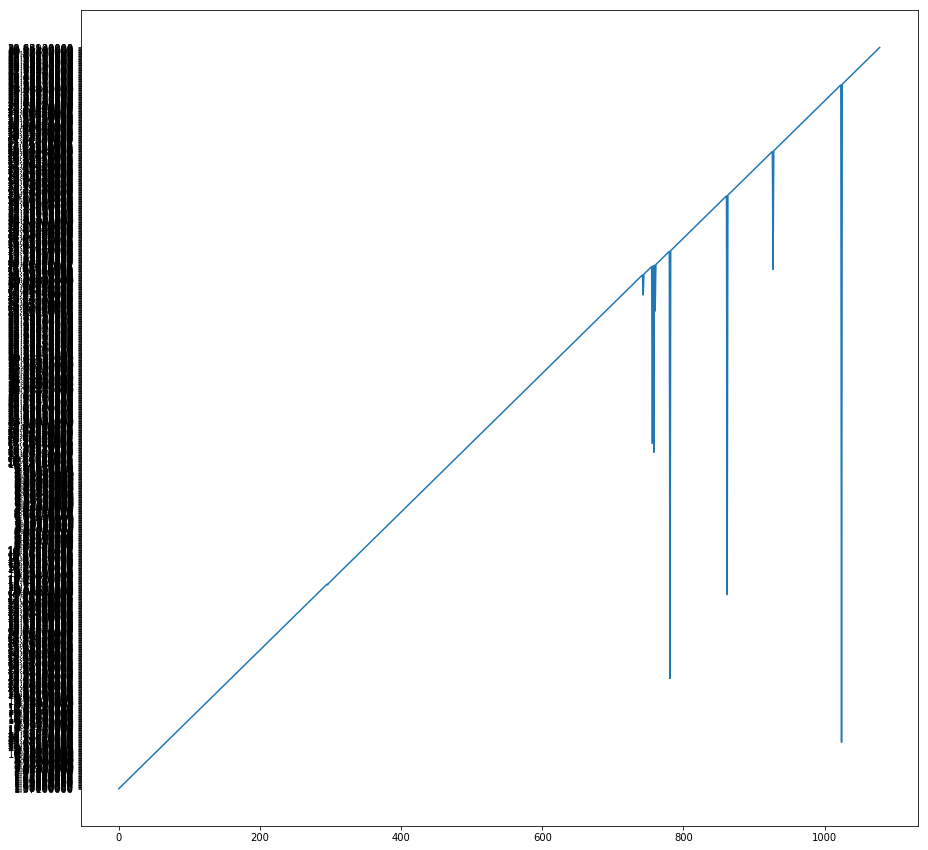

In [29]:
fig, ax = plt.subplots(1,figsize=(15,15))
ax.plot(df['close'].values)

In [ ]:
df = pd.DataFrame(klines)

In [78]:
# save df to pickle so it doesn't have to be downloaded again
df.to_pickle('test_dataset19102020.pkl')

In [79]:
# load dataset from pickle
df = pd.read_pickle('test_dataset19102020.pkl')

Column 4 corresponds to adjusted close while column 6 corresponds to close time (in milliseconds since the 1 Jan, 2017 or the start date specified above. See https://python-binance.readthedocs.io/en/latest/binance.html#binance.client.Client.get_klines

In [80]:
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11
0,1546819200000,0.00157070,0.00172000,0.00154490,0.00157370,17386856.72000000,1547423999999,28326.22221343,478114,8881823.35000000,14472.23109213,0
1,1547424000000,0.00157360,0.00183440,0.00157000,0.00181100,13935439.30000000,1548028799999,23970.18621914,339994,7992114.11000000,13764.19412543,0
2,1548028800000,0.00181100,0.00202250,0.00178970,0.00198210,16853153.77000000,1548633599999,31407.37716738,268969,10379219.69000000,19337.08973242,0
3,1548633600000,0.00198280,0.00204980,0.00174000,0.00196590,19180187.22000000,1549238399999,35859.50353566,368148,10677870.27000000,19997.20414009,0
4,1549238400000,0.00196500,0.00256000,0.00193330,0.00248740,26193595.66000000,1549843199999,60569.48616989,675102,14667831.37000000,33956.21361512,0


In [81]:
print('Time since', startdate)

Time since 1 Jan, 2019


In [82]:
df2 = pd.DataFrame()
col_title = 'Time (ms) since ' + startdate
df2[col_title] = df.iloc[:,6]
df2['Close'] = df.iloc[:,4]
# df2.index = 

In [83]:
df2.iloc[:,0]

0     1547423999999
1     1548028799999
2     1548633599999
3     1549238399999
4     1549843199999
5     1550447999999
6     1551052799999
7     1551657599999
8     1552262399999
9     1552867199999
10    1553471999999
11    1554076799999
12    1554681599999
13    1555286399999
14    1555891199999
15    1556495999999
16    1557100799999
17    1557705599999
18    1558310399999
19    1558915199999
20    1559519999999
21    1560124799999
22    1560729599999
23    1561334399999
24    1561939199999
25    1562543999999
26    1563148799999
27    1563753599999
28    1564358399999
29    1564963199999
          ...      
64    1586131199999
65    1586735999999
66    1587340799999
67    1587945599999
68    1588550399999
69    1589155199999
70    1589759999999
71    1590364799999
72    1590969599999
73    1591574399999
74    1592179199999
75    1592783999999
76    1593388799999
77    1593993599999
78    1594598399999
79    1595203199999
80    1595807999999
81    1596412799999
82    1597017599999


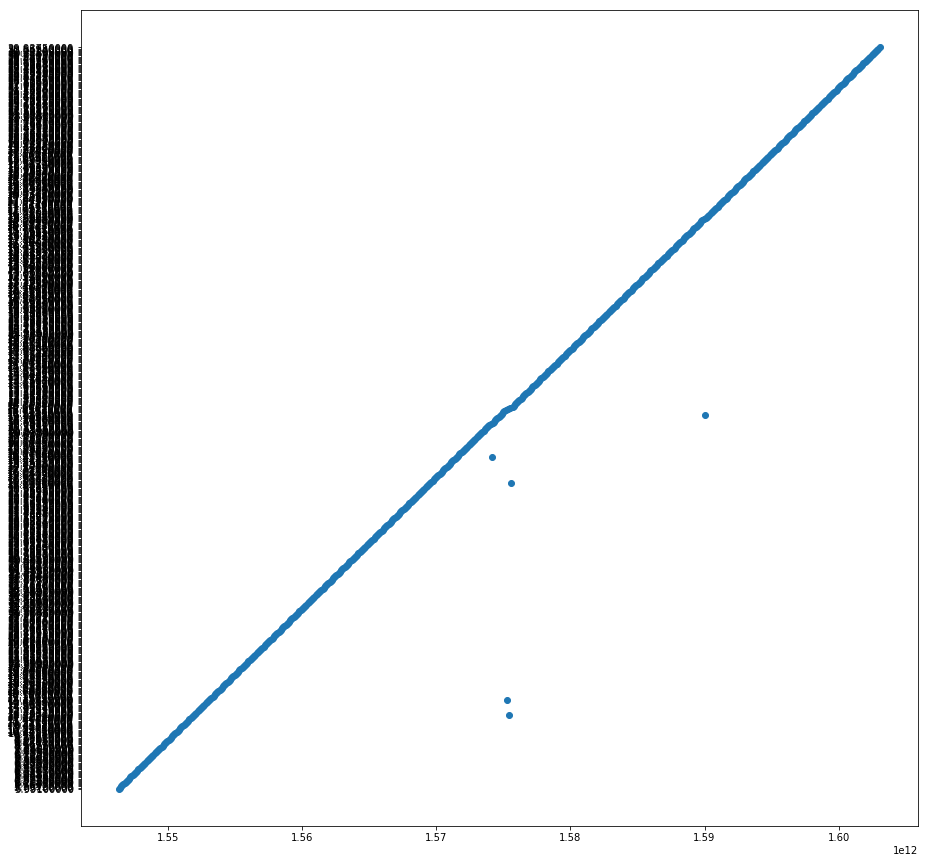

In [101]:
fig, ax = plt.subplots(1,figsize=(15,15))
ax.scatter(df.iloc[:,0],df.iloc[:,4])